# **FACE-MATCHING**

### Cài đặt các thư viện cần thiết

In [29]:
!pip install kagglehub pandas opencv-python facenet_pytorch scikit-learn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


### Download bộ dữ liệu

In [30]:
import kagglehub

# Tải về bộ dữ liệu người nổi tiếng Việt nam từ kaggle:
# https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/data
dataset_path = kagglehub.dataset_download("hariwu1995/vn-celeb")
print("Đường dẫn thư mục dataset:", dataset_path)

Đường dẫn thư mục dataset: /Users/hungth/.cache/kagglehub/datasets/hariwu1995/vn-celeb/versions/1


### Chuẩn bị dữ liệu
Bộ dữ liệu VN-Celeb chứa ảnh của các người nổi tiếng Việt Nam, với cấu trúc thư mục theo danh mục danh tính.

In [31]:
import pandas as pd
import os

vnceleb_path = os.path.join(dataset_path, 'VN-celeb')
classes = os.listdir(vnceleb_path)

# Mỗi thư mục chứa ảnh của một người nên số lượng Id = số lượng thư mục
print(f"Số lượng ID: {len(classes)}")
print("Ví dụ ID:", classes[:5])

Số lượng ID: 1021
Ví dụ ID: ['797', '909', '135', '307', '763']


In [32]:
# Đọc ảnh khuôn mặt và gán nhãn cho từng khuôn mặt
import glob
import cv2
faces_path = [] # Danh sách đường dẫn ảnh
labels = []  # Danh sách nhãn gắn cho từng ảnh

for label in classes:
    # Đường dẫn thư mục ảnh của từng ID
    class_dir = os.path.join(vnceleb_path, label) 
    # Đường dẫn ảnh (Các ảnh có định dạng pnG)
    imgs_path = glob.glob(class_dir + '/*.png')
    for img_path in imgs_path:
        faces_path.append(img_path)
        labels.append(label)
print(f'Tổng số lượng ảnh khuôn mặt: {len(faces_path)}')

# Chia nh tập dữ liệu, sử dụng bộ dữ liệu test để đánh giá mô hình.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(faces_path, labels, test_size=0.05, stratify=labels)

# Đọc ảnh từ bộ dữ liệu test
faces_test = [] # Data ảnh khuôn mặt của bộ dữ liệu test 
labels_test = y_test # Nhãn (ID) của từng ảnh 

for img_path in X_test:
  face = cv2.imread(img_path)
  face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
  face_resized = cv2.resize(face, (160, 160))
  if face_resized is not None:
    faces_test.append(face_resized)
print(f'Số lượng ảnh bộ dữ liệu test: {len(faces_test)}')
print(f'Kích thước ảnh khuôn mặt: {faces_test[0].shape}')


Tổng số lượng ảnh khuôn mặt: 23105
Số lượng ảnh bộ dữ liệu test: 1156
Kích thước ảnh khuôn mặt: (160, 160, 3)


In [33]:
from facenet_pytorch import InceptionResnetV1
import torch

# Tải mô hình pre-trained
facenet = InceptionResnetV1(pretrained='vggface2').eval()

In [34]:
import numpy as np

def get_embedding(face):
    face = np.expand_dims(face, axis=0) / 255.0  # Chuẩn hóa
    face = torch.tensor(face).permute(0, 3, 1, 2).float()  # Chuyển sang tensor
    embedding = facenet(face).detach().numpy()
    return embedding

# Trích xuất vector cho toàn bộ khuôn mặt
embeddings = [get_embedding(face) for face in faces_test]
embeddings = np.vstack(embeddings)

In [35]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import random

# Chọn ngưỡng xác định 2 ảnh có phải của một người ?
threshold = 0.8

# Đánh giá mẫu
def plot_images_with_similarity(face1, face2, similarity):
    """Hiển thị hai ảnh và giá trị similarity"""
    plt.figure(figsize=(6, 4))

    # Hiển thị ảnh 1
    plt.subplot(1, 2, 1)
    plt.imshow(face1)
    plt.axis("off")
    plt.title("Face 1")

    # Hiển thị ảnh 2
    plt.subplot(1, 2, 2)
    plt.imshow(face2)
    plt.axis("off")
    plt.title("Face 2")

    # Kết quả isMatch:
    isMatch =  'Match' if similarity >= threshold else "Not Match"

    # Hiển thị giá trị similarity
    plt.suptitle(f"Cosine Similarity: {similarity:.4f} : {isMatch}", fontsize=16)
    plt.show()


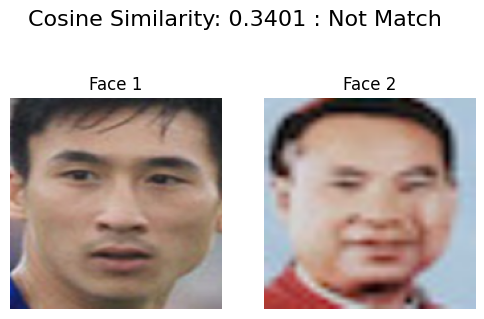

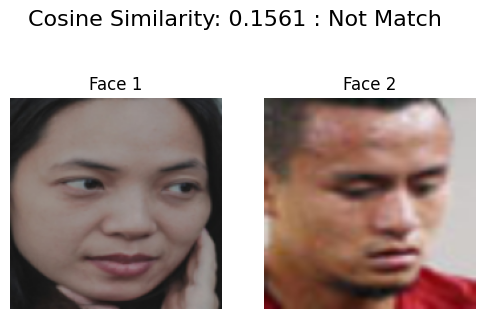

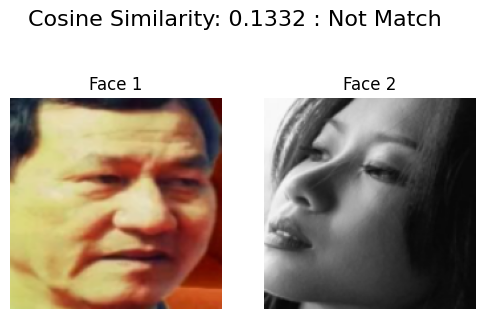

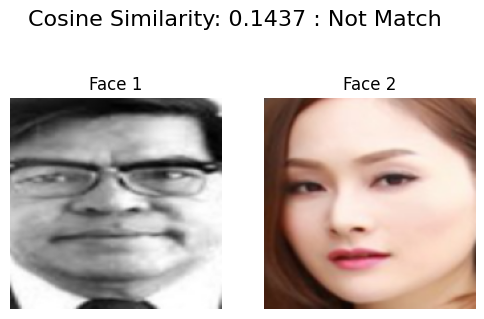

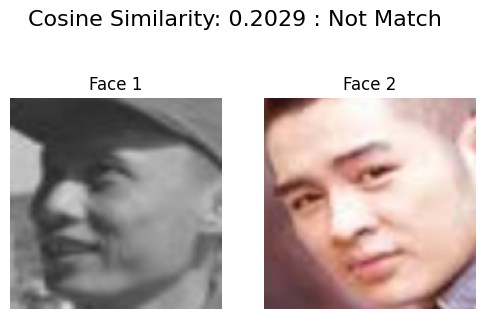

In [36]:
# Đánh giá 5 cặp ảnh ngẫu nhiên, tính toán độ tương đồng giữa các cặp ảnh được chọn
for i in range(5):
  # Chọn ngẫu nhiên 2 ảnh từ tập test
  idx1, idx2 = random.sample(range(len(faces_test)), 2)
  # Data ảnh 
  image1 = faces_test[idx1]
  image2 = faces_test[idx2]
    
  # Data embedding của 2 ảnh 
  embedding1 = embeddings[idx1]
  embedding2 = embeddings[idx2]

  # Tính cosine similarity
  similarity = cosine_similarity([embedding1], [embedding2])[0][0]

  # Hiển thị kết quả
  plot_images_with_similarity(image1, image2, similarity)

In [37]:
from sklearn.metrics import roc_auc_score, accuracy_score

label_true = []
label_pred = []

for i in range(len(embeddings)):
    for j in range(i + 1, len(embeddings)):
        is_same = labels_test[i] == labels_test[j]
        similarity = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
        label_true.append(is_same)
        label_pred.append(similarity)

# Đánh giá ROC AUC
roc_score = roc_auc_score(label_true, label_pred)
print("ROC AUC Score:", roc_score)

ROC AUC Score: 0.9729275983661732


AUC có giá trị nằm trong khoảng từ 0 đến 1:
* 1.0: Mô hình phân loại hoàn hảo (phân biệt rõ ràng các lớp).
* 0.5: Mô hình không phân biệt được, tương đương với đoán ngẫu nhiên.
* < 0.5: Hiệu suất kém, mô hình dự đoán ngược so với thực tế.

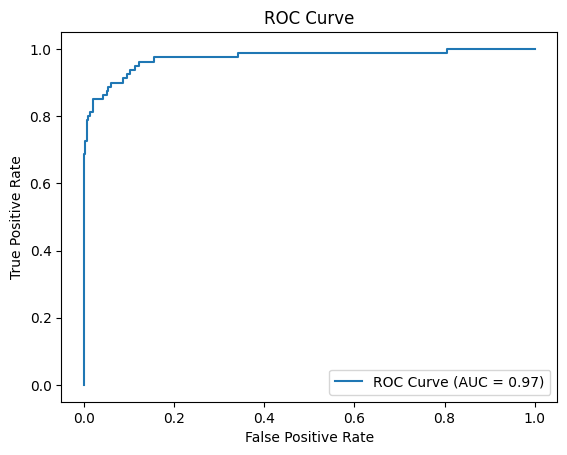

In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(label_true, label_pred)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_score:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()